### Imports

In [1]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, SmartCorrelatedSelection, SelectByShuffling, RecursiveFeatureElimination
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from feature_engine.datetime import DatetimeFeatures
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, RFE # Recursive Feature Elimination
from ta import add_all_ta_features
from ta.utils import dropna

### Reading Data from Excel daily_dataframe_main

In [2]:
# Takes 1 min 30 secs to run
Variables = pd.read_excel('daily_dataframe_main.xlsx', header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel('daily_dataframe_main.xlsx',sheet_name= 'Response' ,index_col=0)

# Just using Unadjusted data for now
Response = Response[['LB_Close','Close_ret','Close_Up_Down']]

### Imputing Values
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Check:</b> Backfilling and then frontfilling Variables DataFrame, and filling zeros with Median? - Check if it makes sense
</div>


In [3]:
Variables.fillna(method='bfill', inplace=True)
# Variables.fillna(method='ffill', inplace=True)
# Replacing 0 with Median Values
# Variables.replace(to_replace=0, method='bfill', inplace=True) 
# Variables.replace(to_replace=0, method=Variables.median(), inplace=True) 

### Date Engineering

In [4]:
Variables['day'] = Variables.index.day
Variables['month'] = Variables.index.month
Variables['year'] = Variables.index.year
Variables['weekday'] = Variables.index.weekday
Variables['week'] = Variables.index.week
Variables['weekofyear'] = Variables.index.weekofyear
Variables['quarter'] = Variables.index.quarter
Variables['dayofyear'] = Variables.index.dayofyear
Variables['dayofweek'] = Variables.index.dayofweek
Variables['is_month_end'] = Variables.index.is_month_end
Variables['is_month_start'] = Variables.index.is_month_start
Variables['is_quarter_end'] = Variables.index.is_quarter_end
Variables['is_quarter_start'] = Variables.index.is_quarter_start
Variables['is_year_end'] = Variables.index.is_year_end
Variables['is_year_start'] = Variables.index.is_year_start
Variables['is_leap_year'] = Variables.index.is_leap_year


C:\Users\Fanjum_cwp\AppData\Local\Temp\2\ipykernel_20380\3905641289.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Variables['week'] = Variables.index.week
C:\Users\Fanjum_cwp\AppData\Local\Temp\2\ipykernel_20380\3905641289.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Variables['weekofyear'] = Variables.index.weekofyear


### Adding Technical Analysis Indicators

In [ ]:
TA_df = Variables.loc[:,('Lumber_OHLCV',)][['LB_High','LB_Low','LB_Close','LB_Volume','LB_openInterest']]
TA_df.columns = ['High','Low','Close','Volume','OpenInterest']
TA_df['Open'] = TA_df['Close'].shift(-1)

# TA_df['weekday'] = Variables.index.weekday
# TA_df = TA_df[~TA_df.weekday.isin([5,6])]
# TA_df = TA_df.drop(['weekday'],axis=1)

TA_df = dropna(TA_df)
TA_df.sort_index(ascending=True, inplace=True)
TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
TA_df.sort_index(ascending=False, inplace=True)
TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
TA_df.columns = [str('TA_') + TA_df.columns]
TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
Variables = pd.concat([Variables,TA_df], axis=1)

C:\Users\Fanjum_cwp\AppData\Local\Temp\2\ipykernel_23660\2267681742.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  TA_df = Variables.loc[:,('Lumber_OHLCV',)][['LB_High','LB_Low','LB_Close','LB_Volume','LB_openInterest']]
c:\source\2x4_data\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\source\2x4_data\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\source\2x4_data\venv\lib\site-packages\ta\trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
c:\source\2x4_data\venv\lib\site-packages\ta\trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

### Replacing punctuation strings in column names

In [ ]:
cols = [str(w).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip() for w in Variables.columns]
Variables.columns = cols

<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> For now using custom based method - but change it eventually with Feature-engine etc. Check which method makes more sense
</div>

In [ ]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value in column.
        Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
        
Variables = DataFrameImputer().fit_transform(Variables)


### Concatenating Variables & Response
    -- Choose Response Variable here - LB_Close, Close_ret, Close_Up_Down, OR Adjusted Data from above

In [9]:
# Choose Target Variable here - LB_Close	Close_ret	Close_Up_Down OR Adjusted Data from above
Target_choice = 'Close_Up_Down'
data = pd.concat([Variables, Response[Target_choice]], axis=1)
data.index = pd.DatetimeIndex(data.index)
data.sort_index(ascending = False, inplace = True)

### 
<div style="color: Red; font-size:22px;" class="alert alert-block alert-warning">  Restricting the dataset since 2011 only as well as only Up (+1) and Down (-1) Moves but no neutral (0)
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Issues is we have some forward fills which doesn't represent data correctly
</div>


In [10]:
data_restricted = data[data.index > '2011-01-01']
data_restricted = data_restricted[(data_restricted.Close_Up_Down == 1) | (data_restricted.Close_Up_Down == -1)]

### Remove Variables with all NaNs
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why these variables have NaNs
</div>


In [11]:
data_restricted.drop(data_restricted.columns[data_restricted.isna().all()].to_list(), axis=1, inplace=True)
data_restricted.drop(data_restricted.columns[data_restricted.isnull().all()].to_list(), axis=1, inplace=True)
pd.Series(data_restricted.dtypes.values).value_counts()

float64    745
int64       11
bool         7
dtype: int64

### Change Bool cols (mostly date columns such as Is_year_end etc.) to int columns

In [12]:
list_of_bool_cols = data_restricted.columns[data_restricted.dtypes.values == 'bool'].to_list()
for col in list_of_bool_cols:
    data_restricted[col] = data_restricted[col].astype(int)

### Dictionary of Training, Testing & Validation

### Splitting the Dataset in 3 - Training, Testing & Validation

In [13]:
Validation_date_start = '2022-01-01'
Validation = data_restricted[data_restricted.index >= Validation_date_start]
data_restricted = data_restricted[data_restricted.index < Validation_date_start]
X_val,  y_val  = Validation.iloc[:,:-1], Validation.iloc[:,-1] # last column is the response variable

X_train, X_test, y_train, y_test = train_test_split(
    data_restricted.drop(labels=data_restricted.columns[-1], axis=1),  # drop the target
    data_restricted[Target_choice],  # just the target
    test_size=0.20, shuffle = False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((2200, 762), (550, 762), (2200,), (550,), (116, 762), (116,))

### Remove all constant Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features have only one value
</div>

In [14]:
NonConstantFeatures =DropConstantFeatures(tol=1, variables=None, missing_values='raise')
NonConstantFeatures.fit(X_train)
print("Total Constant Variables:",len(NonConstantFeatures.features_to_drop_))
print(NonConstantFeatures.features_to_drop_[:3])
print("First Variable contains all:",X_train[NonConstantFeatures.features_to_drop_[0]].unique())

X_train = NonConstantFeatures.transform(X_train)
X_test = NonConstantFeatures.transform(X_test)
X_val = NonConstantFeatures.transform(X_val)

X_train.shape, X_test.shape

Total Constant Variables: 42
['LumberTracklumberimportus ToChina', 'WesternLumberproductionwestern Day', 'WesternLumberaveragepricecoastalhimfir StandandBtrRL2x4']
First Variable contains all: [0.]


((2200, 720), (550, 720))

### Remove quasi-constant features - Last Line of this Segment

In [15]:
# Percentage of observations showing each of the different values of the variable
NonQuasiConstantFeatures = DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')
NonQuasiConstantFeatures.fit(X_train)
print("Total Quasi Constant Variables:",len(NonQuasiConstantFeatures.features_to_drop_))
print(NonQuasiConstantFeatures.features_to_drop_)


Total Quasi Constant Variables: 10
['FREDMonthly Housing Affordability Index Fixed', 'ismonthend', 'ismonthstart', 'isquarterend', 'isquarterstart', 'isyearend', 'TAvolatilitybbhi', 'TAvolatilitybbli', 'TAtrendpsarupindicator', 'TAtrendpsardownindicator']


### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Check:</b> Not Removing FEW Quasi Constant Features for now as: 
</div>

    1. Some typically have 1 value for most of the time such as US_MBA_Mortgage_Applications_WoW so not unusual.                
    2. Some seem Important for now such as ('Canadian_Pacific', 'Lumber & Wood Prods').

In [16]:
for var in NonQuasiConstantFeatures.features_to_drop_:
    print(var)
    print(pd.DataFrame(X_train[var].value_counts(normalize=True)).iloc[:10,0])
    print("\n")

# Not_Removing_Quasi_List = ['Investingdotcom USMortgageMarketIndex','Investingdotcom USMBAMortgageApplicationsWoW',
# 'CanadianPacific Lumber  Wood Prods', 'FREDMonthly Housing Affordability Index Fixed']

Not_Removing_Quasi_List = ['FREDMonthly Housing Affordability Index Fixed']

for var in Not_Removing_Quasi_List:
    NonQuasiConstantFeatures.features_to_drop_.remove(var)

FREDMonthly Housing Affordability Index Fixed
144.094695    0.935909
150.100000    0.010000
151.000000    0.009545
148.400000    0.009545
144.500000    0.009545
150.000000    0.009545
154.400000    0.009091
147.600000    0.006818
Name: FREDMonthly Housing Affordability Index Fixed, dtype: float64


ismonthend
0    0.966818
1    0.033182
Name: ismonthend, dtype: float64


ismonthstart
0    0.969545
1    0.030455
Name: ismonthstart, dtype: float64


isquarterend
0    0.988182
1    0.011818
Name: isquarterend, dtype: float64


isquarterstart
0    0.990455
1    0.009545
Name: isquarterstart, dtype: float64


isyearend
0    0.996818
1    0.003182
Name: isyearend, dtype: float64


TAvolatilitybbhi
0.0    0.948636
1.0    0.051364
Name: TAvolatilitybbhi, dtype: float64


TAvolatilitybbli
0.0    0.965
1.0    0.035
Name: TAvolatilitybbli, dtype: float64


TAtrendpsarupindicator
0.0    0.948182
1.0    0.051818
Name: TAtrendpsarupindicator, dtype: float64


TAtrendpsardownindicator
0.0    0.948636

In [17]:
print(len(NonQuasiConstantFeatures.features_to_drop_),NonQuasiConstantFeatures.features_to_drop_)
X_train = NonQuasiConstantFeatures.transform(X_train)
X_test = NonQuasiConstantFeatures.transform(X_test)
X_val = NonQuasiConstantFeatures.transform(X_val)
X_train.shape, X_test.shape

9 ['ismonthend', 'ismonthstart', 'isquarterend', 'isquarterstart', 'isyearend', 'TAvolatilitybbhi', 'TAvolatilitybbli', 'TAtrendpsarupindicator', 'TAtrendpsardownindicator']


((2200, 711), (550, 711))

### Remove Duplicate Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features are duplicated of each other. Each Variable in a curly bracket is a duplicate
</div>

In [18]:
# set up the selector
NonDuplicatedValues = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features, this might take a while
NonDuplicatedValues.fit(X_train)

print(len(NonDuplicatedValues.duplicated_feature_sets_))
NonDuplicatedValues.duplicated_feature_sets_

43


[{'FREDDaily 7Day Federal Funds Effective Rate', 'OverNightRates EFFR'},
 {'LumberTrackordersus South',
  'LumberTrackproductionus South',
  'LumberTrackshipmentus South'},
 {'LumberTrackinventoryus South', 'LumberTracknorthamericaninventory South'},
 {'LumberTracknorthamericanunfilledorder South',
  'LumberTrackunfilledordersus South'},
 {'LumberTrackconsumptionlumbercanada MinusExports',
  'LumberTracklumberexportcanada TotalLumberExports'},
 {'LumberTrackconsumptionlumberus PlusImports',
  'LumberTracklumberimportus TotalLumberImports'},
 {'CFTCdisaggregated OpenInterestAll',
  'CFTClegacy OpenInterestAll',
  'CFTClegacy OpenInterestOld'},
 {'CFTCdisaggregated TotReptPositionsLongAll',
  'CFTClegacy TotalReportablePositionsLongOld'},
 {'CFTCdisaggregated TotReptPositionsShortAll',
  'CFTClegacy TotalReportablePositionsShortAll',
  'CFTClegacy TotalReportablePositionsShortOld'},
 {'CFTCdisaggregated ChangeinOpenInterestAll',
  'CFTClegacy ChangeinOpenInterestAll'},
 {'CFTClegacy Nonc

In [19]:
# remove the duplicated features
X_train = NonDuplicatedValues.transform(X_train)
X_test = NonDuplicatedValues.transform(X_test)
X_val = NonDuplicatedValues.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((2200, 665), (550, 665), (116, 665))

### Keep copy of the dataset except constant and duplicated variables to measure the performance of machine learning models at the end of the notebook

In [20]:
X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Smart Correlation Selection based on various Method (‘pearson’, ‘spearman’, ‘kendall’) and selection_method (“missing_values”, “cardinality” (the number of unique values of each variable), “variance”, “model_performance”:)
https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SmartCorrelatedSelection.html                             
https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall

In [21]:
# random forest
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="spearman",
    threshold=0.9,
    missing_values="raise",
    selection_method="variance",
    estimator=rf,
    scoring="roc_auc",
    cv=3,
)

sel.fit(X_train, y_train)

c:\source\2x4_data\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:302: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\source\2x4_data\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:302: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\source\2x4_data\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:302: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\source\2x4_data\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:302: FutureWarning: Passing a set as an indexer is de

SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                          n_jobs=-1),
                         method='spearman', missing_values='raise',
                         selection_method='variance', threshold=0.9)

In [22]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((2200, 394), (550, 394), (116, 394))

### Univariate Selection Methods - Mostly just examine linear relationships

#### Mutual Information

In [23]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)

# Plot
# mi.plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

# select features
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

Index(['lumbermovingaverages MA200', 'Weeklyrealtor pricereducedshareyy',
       'day', 'TAvolumeem', 'TAvolatilitykchi', 'TAvolatilitykcli',
       'TAvolatilityui', 'TAtrendcci', 'TAtrendaroonup', 'TAmomentumstochrsi',
       'TAmomentumstochrsik', 'TAmomentumuo', 'TAmomentumstochsignal',
       'TAmomentumroc', 'TAothersdr'],
      dtype='object')

#### Chi-square Statistic - only suited for classification!                                         
https://www.udemy.com/course/feature-selection-for-machine-learning/learn/lecture/22495182#questions
https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Fisher-score.ipynb

In [24]:
# calculate the chi2 p_value between each of the variables and the target
# chi2 returns 2 arrays, one contains the F-Scores which are then evaluated against the chi2 distribution to obtain the pvalue. The pvalues are in the second array

# Input X must be non-negative
X_train_non_negative = X_train[X_train.columns[((X_train < 0).sum(axis=0) == 0).values]]
f_score = chi2(X_train_non_negative.fillna(0), y_train)
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_non_negative.columns
pvalues.sort_values(ascending=True, inplace = True)
extremely_low_p_values = len(pvalues[pvalues < 1e-100])
sel_ = SelectKBest(chi2, k= extremely_low_p_values).fit(X_train_non_negative, y_train)
X_train_non_negative.columns[sel_.get_support()] # display features

# X_train = sel_.transform(X_train)
# X_test = sel_.transform(X_test)

Index(['LumberOHLCV LBopenInterest',
       'Investingdotcom USMortgageRefinanceIndex',
       'monthlyrealtor activelistingcount', 'monthlyrealtor newlistingcount',
       'monthlyrealtor pendinglistingcount',
       'monthlyrealtor totallistingcount',
       'FREDMonthly Advance Retail Sales Retail Trade',
       'FREDWeekly As of Wednesday Assets Total Assets Total Assets Less Eliminations from Consolidation Wednesday Level',
       'FREDWeekly Ending Saturday Initial Claims',
       'Construction Spending HighwayandstreetTotal',
       'Construction Spending NonresidentialTotal',
       'Construction Spending NonresidentialPrivate',
       'Construction Spending TotalConstructionTotal',
       'New Home Sales SOLDAVERAG', 'barometerwestern Inventories',
       'barometercoast Unfilled', 'barometercoast Inventories',
       'barometerinland Unfilled', 'barometerinland Inventories',
       'CFTCdisaggregated OpenInterestAll',
       'CFTCdisaggregated MMoneyPositionsLongAll',
       

#### Anova - tests 2 samples have same mean

Assumptions:
Sample are independant & normally distributed, homegeneity of variance

In [25]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is one array with f-scores and one array with the pvalues

univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True, inplace = True) # The smaller the p_value the more predictive the feature is

pvalue_above_5_percent = len(univariate[univariate < 0.05])
sel_ = SelectKBest(f_classif, k=pvalue_above_5_percent).fit(X_train, y_train)
features_to_keep = sel_.get_feature_names_out()
features_to_keep

# select features
# X_train_anova = sel_.transform(X_train)
# X_test_anova = sel_.transform(X_test)

# # numpy array to dataframe
# X_train_anova = pd.DataFrame(X_train_anova)
# X_train_anova.columns = features_to_keep

# X_test_anova = pd.DataFrame(X_test_anova)
# X_test_anova.columns = features_to_keep

# X_train_anova.shape, X_test_anova.shape



array(['LumberOHLCV LBopenInterest', 'lumbermovingaverages MA200',
       'lumbermovingaverages MA100', 'lumbermovingaverages MA50',
       'Investingdotcom USMBAPurchaseIndex',
       'Investingdotcom USMortgageRefinanceIndex',
       'Investingdotcom USMortgageMarketIndex',
       'Weeklyrealtor activelistingcountyy',
       'Weeklyrealtor pricereducedcountyy', 'GSCPI GSCPI',
       'TreasuryTerms ACMY03', 'TreasuryTerms ACMY10', 'Yahoo GCF',
       'FREDDaily Market Yield on US Treasury Securities at 30Year Constant Maturity Quoted on an Investment Basis',
       'FREDMonthly Labor Force Participation Rate',
       'FREDMonthly EmploymentPopulation Ratio',
       'FREDMonthly Personal Saving Rate',
       'FREDMonthly Industrial Production Total Index',
       'FREDMonthly Capacity Utilization Total Index',
       'FREDWeekly As of Wednesday Assets Total Assets Total Assets Less Eliminations from Consolidation Wednesday Level',
       'New Residential Construction COMPLETIONSTOTAL',

### Wrapper Methods

### Embedded Methods | Tree Importance

31


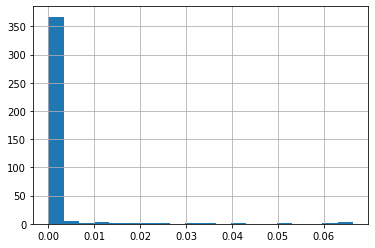

In [26]:
# Selects features whose importance is greater than the threshold. - Thershold is the mean importance of all features
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
TopNFeatures = pd.DataFrame(index = sel_.estimator_.feature_names_in_.tolist(),data = sel_.estimator_.feature_importances_, columns = ['Imp']).sort_values(by='Imp',ascending=False).head(20).index.tolist()
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20);

In [27]:
TopNFeatures

['TAtrendcci',
 'TAvolatilitykcp',
 'TAmomentumstochrsi',
 'TAvolatilitykcli',
 'TAvolatilitykchi',
 'TAothersdr',
 'TAvolumevpt',
 'TAvolumeem',
 'TAmomentumroc',
 'TAmomentumuo',
 'TAtrendadxneg',
 'lumbermovingaverages MA50',
 'TAtrendmacddiff',
 'TAmomentumstochrsik',
 'TAtrendadxpos',
 'lumbermovingaverages MA100',
 'TAmomentumstochsignal',
 'TAvolumefi',
 'TAtrendaroonup',
 'LumberOHLCV LBopenInterest']

### Embedded Methods | Tree Importance Recursively

In [28]:
# Takes 1:44 mins to run
sel_ = RFE(RandomForestClassifier(n_estimators=100,  max_depth=3, n_jobs=-1), n_features_to_select=30).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
selected_features


30


Index(['LumberOHLCV LBopenInterest', 'LumberContractSpreads FirstThird',
       'lumbermovingaverages MA100', 'lumbermovingaverages MA50',
       'LumberBasis basis', 'Investingdotcom USMBAPurchaseIndex',
       'Investingdotcom USMortgageRefinanceIndex',
       'FREDWeekly As of Wednesday Assets Total Assets Total Assets Less Eliminations from Consolidation Wednesday Level',
       'CFTClegacy NoncommercialPositionsSpreadingAll',
       'FEALumberAdvisorvalue Softwood Lumber Dealer StocksConsumption Ratio United States',
       'FEALumberAdvisorvalue Softwood Lumber Consumption Industrial Production United States',
       'TAvolumefi', 'TAvolumeem', 'TAvolumevpt', 'TAvolatilitykcw',
       'TAvolatilitykcp', 'TAvolatilitykchi', 'TAvolatilitykcli',
       'TAtrendmacddiff', 'TAtrendvortexindpos', 'TAtrendadxpos',
       'TAtrendadxneg', 'TAtrendcci', 'TAtrendaroonup', 'TAmomentumstochrsi',
       'TAmomentumstochrsik', 'TAmomentumuo', 'TAmomentumstochsignal',
       'TAmomentumroc', 'T

In [29]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
rf.fit(X_train[selected_features].fillna(0), y_train)
y_pred = rf.predict(X_test[selected_features].fillna(0))
y_valid_pred = rf.predict(X_val[selected_features].fillna(0))
print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val.fillna(0), y_valid_pred))


Test Accuracy: 0.7109090909090909
Validation Accuracy: 0.5603448275862069


In [30]:
print('Train set')
pred = rf.predict_proba(X_train[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

print('Test set')
pred = rf.predict_proba(X_test[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

print('Validation set')
pred = rf.predict_proba(X_val[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_val, pred[:, 1])))

Train set
Random Forests roc-auc: 0.7460833545460855
Test set
Random Forests roc-auc: 0.7845968712394704
Validation set
Random Forests roc-auc: 0.6610169491525424


### Feature Selection by Random Shuffling

In [31]:
# Takes 1 min to run - You can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(n_estimators=50, max_depth=2, n_jobs=-1)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
)

sel.fit(X_train, y_train)


SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=50,
                                                   n_jobs=-1),
                  threshold=0)

In [32]:
sel.initial_model_performance_ # performance of model trained with all features

0.6329201664908894

In [33]:
# pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(16,6));

In [34]:
# features that will be removed

print(len(sel.features_to_drop_))
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape

340


((2200, 54), (550, 54))

In [35]:
rf.fit(X_train, y_train)
print( 'train auc score: ',roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print('test auc score: ', roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))
print('Validation auc score: ', roc_auc_score(y_val, (rf.predict_proba(X_val))[:, 1]))

train auc score:  0.7212309622435047
test auc score:  0.785225003636556
Validation auc score:  0.6384180790960452


In [36]:
X_train.columns

Index(['lumbermovingaverages MA100', 'lumbermovingaverages MA50',
       'Investingdotcom USMBAPurchaseIndex',
       'monthlyrealtor pendinglistingcountyy',
       'monthlyrealtor mediansquarefeet', 'monthlyrealtor mediansquarefeetyy',
       'TreasuryTerms ACMY10', 'Yahoo CFPTO',
       'FREDDaily Market Yield on US Treasury Securities at 30Year Constant Maturity Quoted on an Investment Basis',
       'FREDDaily US Dollars to Euro Spot Exchange Rate',
       'FREDMonthly Personal Saving Rate',
       'New Residential Construction COMPLETIONSTOTAL',
       'New Residential Construction PERMITSTOTAL',
       'Construction Spending EducationalPrivate',
       'LumberTracklogimportus NonCanadianSources',
       'LumberTracklumberexportus ToChina',
       'LumberTracknorthamericanshipment Coast',
       'LumberTracknorthamericanorder Other',
       'LumberTracknorthamericaninventory Inland',
       'WesternLumberorderswestern Inland',
       'WesternLumberunfilledorderwestern CalRW',
    

### Recursive Feature Elimination

In [37]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [5]:
# NOT WORKING

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
# sel.fit(X_train, y_train)

NameError: name 'model' is not defined

In [ ]:
sel.initial_model_performance_

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [ ]:
# Number of features that will be removed

len(sel.features_to_drop_)

### Random Forest

In [ ]:
features = list(X_train.columns)
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance.sort_values(by=['importance'], ascending=False, inplace=True)
y_pred = rf.predict(X_test[features].fillna(0))
y_valid_pred = rf.predict(X_val[features].fillna(0))

print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val .fillna(0), y_valid_pred))

### Compare the performance in machine learning algorithms

In [ ]:
X_train_basic_filter.shape, X_test_basic_filter.shape, X_train.shape, X_test.shape

In [ ]:

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [ ]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

In [ ]:
# Final model
run_randomForests(X_train, X_test, y_train, y_test)

### Logistic Regression

In [ ]:
# create a function to build logistic regression and compare performance in train and test set

from sklearn.metrics import confusion_matrix

def run_logistic(X_train, X_test, y_train, y_test):
    
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

scaler = StandardScaler().fit(X_train)

run_logistic(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Pipelines:</b> Final Code will look like this but for now work through issues above 
</div>

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlation', SmartCorrelatedSelection(method = 'spearman' ,selection_method='variance')),])

pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

X_train.shape, X_test.shape, X_val.shape


In [ ]:
print(len(pipe.named_steps['constant'].features_to_drop_))
pipe.named_steps['duplicated'].features_to_drop_

# NOT USING - for reference

### Correlated Features - Brute Force approach

In [ ]:
def correlation(dataset, threshold):
    
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
             
                print(abs(corr_matrix.iloc[i, j]),":", corr_matrix.columns[i], "<< - >>", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

# corr_features = correlation(X_train, 0.9)
# len(set(corr_features))


In [ ]:
# corr_features = correlation(X_train, 0.9)

### Correlated Features - Second Approach

In [ ]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1] # Not Interested in the correlation with 1 since will be with the same variable
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

In [ ]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))



In [ ]:
# for group in correlated_groups:
#     print(group)
#     print()

In [ ]:
#Choose Group Index
group_index = 1

group = correlated_groups[group_index]
var = group.feature1.unique()[0]

# add all features of the group to a list
features = list(group['feature2'].unique())+[var]

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']

print(var)
importance.sort_values(by='importance', ascending=False)


In [ ]:
# for feature in group['feature2']:
#     plt.scatter(X_train[var], X_train[feature])
#     plt.xlabel(feature)
#     plt.ylabel(var)
#     plt.show()

### Just an example to show one group of how smart correlation works

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

group = sel.correlated_feature_sets_[0]

# build random forest with cross validation for each feature
for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=3,
        return_estimator=False,
        scoring='accuracy',
    )

#  scoring='roc_auc' does not support categorical data.

    print(f, model["test_score"].mean())

### Bottom